In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import random

import pathlib
import os
import matplotlib.pyplot as plt

#from tensorflow_docs.plots import HistoryPlotter
#from tensorflow_docs.modeling import EpochDots
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

tf.keras.backend.set_floatx('float64')

In [2]:
#set seed
np.random.seed(42)
tf.random.set_seed(42)

In [3]:
import sys
sys.path.append('..')

In [4]:
#Load data
path = "../data/descriptor/DescriptorData.csv"
df=pd.read_csv(path)
df.columns

Index(['material_id', 'energy', 'energy_per_atom', 'band_gap',
       'total_magnetization', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       '10', '11', '12', '13'],
      dtype='object')

In [5]:
#Inspect data
df[df["material_id"]=="mp-19395"]

,material_id,energy,energy_per_atom,band_gap,total_magnetization,0,1,2,3,4,5,6,7,8,9,10,11,12,13
16657,mp-19395,-85.492408,-7.124367,1.0729,1.500000e-07,14.5,3.5,-8.5,-5.5,6.0,2.0,4.5,0.5,4.5,-1.5,2.688062,-0.187277,1.902257,0.004483


In [6]:
y=df["band_gap"] #select feature to predict
toDrop=["material_id", "total_magnetization", "energy", "energy_per_atom", "band_gap"] #drop the other predicted features, and id
X=df.drop(columns=toDrop) #drop these unwanted features
X

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,6.5,1.5,1.5,0.5,3.0,2.0,8.800000,0.800000,7.20000,-4.800000,4.413094,-1.060947,3.352150,0.000002
1,17.5,3.5,-9.5,-3.5,1.5,0.5,3.500000,-2.500000,3.00000,1.000000,8.805744,-4.097701,6.857758,4.503737
2,15.5,5.5,-5.5,-5.5,5.0,1.0,4.333333,2.333333,5.00000,-1.000000,3.188573,0.141018,2.782234,0.020056
3,13.0,1.0,-5.0,-1.0,2.0,-1.0,7.000000,-1.000000,8.00000,4.000000,3.074499,0.527501,2.546999,-0.000000
4,12.0,3.0,-3.0,-2.0,4.0,2.0,7.000000,1.000000,8.00000,-4.000000,3.246873,-0.584746,2.691912,0.000007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18957,20.0,1.0,-13.0,2.0,10.0,-6.0,2.375000,-0.375000,2.50000,0.500000,3.380378,0.891985,2.384921,-0.510342
18958,14.5,5.5,-4.5,-7.5,9.0,3.0,4.000000,-0.000000,3.00000,-1.000000,5.153850,-0.563046,2.996383,-0.005741
18959,15.0,5.0,-4.0,-8.0,1.0,0.0,6.000000,0.000000,8.00000,0.000000,3.600000,0.000000,3.117691,0.000000
18960,18.5,0.5,-13.5,-1.5,6.0,4.0,4.200000,-1.800000,5.40000,0.400000,3.324509,-1.130982,2.717591,1.195841


In [7]:
#For devices with no gpu, run this to hard code running on cpu
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf #reimport tesnorflow to make it work

In [8]:
y=y>0
y

0        False
1         True
2        False
3        False
4        False
         ...  
18957     True
18958     True
18959    False
18960     True
18961    False
Name: band_gap, Length: 18962, dtype: bool

In [9]:
#split input data into train and test datasets, using sklearn 
#test_size determines fraction for test set
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 42, test_size=0.20, stratify=y) 
train_X, val_X=train_X.to_numpy(), val_X.to_numpy()      #transfrom into numpy arrays

In [10]:
#Normalize input
normalize=False                             #Normalization not done, experimentation showed it made network learning worse
if normalize:                       
    normaliser = preprocessing.Normalizer() #create a sklearn normlaizer

    train_X=normaliser.fit_transform(train_X) #fit it and transform taining data
    val_X=normaliser.transform(val_X) #use normalizer fitted to training data to normalize validation set

In [11]:
batch_size=128
train_len=train_X.shape[0]
val_len=val_X.shape[0]
train_dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))#make dataset from pandas dfs
test_dataset=tf.data.Dataset.from_tensor_slices((val_X, val_y))
                                  
test_dataset = test_dataset.shuffle(val_len, seed=42).batch(batch_size) #shuffle datasets, batch them with batch_size
train_dataset = train_dataset.shuffle(train_len, seed=42).batch(batch_size)

features, labels=next(iter(train_dataset)) #just test and print some example feature matrices

print(features[:5])
print(features.shape) #shape of input tensor
print("Data preprocessed")

tf.Tensor(
[[ 1.05000000e+01  7.50000000e+00 -2.50000000e+00 -3.50000000e+00
   4.00000000e+00 -2.00000000e+00  7.00000000e+00 -1.00000000e+00
   8.00000000e+00  4.00000000e+00  3.34401976e+00  6.01852895e-01
   2.77650011e+00 -2.31335672e-06]
 [ 1.10000000e+01  6.00000000e+00 -5.00000000e+00 -6.00000000e+00
   1.10000000e+01 -1.00000000e+00  2.65000000e+00 -8.50000000e-01
   4.45000000e+00  4.50000000e-01  2.86607418e+00 -2.24909357e-01
   2.88687820e+00 -2.99392834e-03]
 [ 9.00000000e+00  1.00000000e+00  4.00000000e+00 -0.00000000e+00
   2.00000000e+00 -1.00000000e+00  6.00000000e+00 -2.00000000e+00
   8.00000000e+00  4.00000000e+00  4.81345857e+00  8.21503427e-01
   3.99195515e+00 -7.43530353e-03]
 [ 1.05000000e+01  1.50000000e+00 -1.50000000e+00 -2.50000000e+00
   1.20000000e+01 -4.00000000e+00  4.50000000e+00 -1.50000000e+00
   3.75000000e+00 -7.50000000e-01  2.79753488e+00 -2.22251987e-01
   2.74197189e+00 -1.66688990e-01]
 [ 1.25000000e+01  6.50000000e+00 -5.50000000e+00 -9.5000

In [12]:
labels[:5] #check that labels look good

<tf.Tensor: id=53, shape=(5,), dtype=bool, numpy=array([False, False, False, False, False])>

Now, build model. Start with simple 2 layer NN

In [13]:
def build_model():

    initial=tf.keras.initializers.he_normal(seed=42) #create initializer for 

    
    model = keras.Sequential([
        layers.Dense(50, activation='relu', input_shape=[features.shape[1]], 
                    kernel_initializer=initial,
                bias_initializer='zeros'), #first layer, takes input, 50 nodes
        layers.BatchNormalization(), #batch normalization
        layers.Dropout(0.5), #dropout
        layers.Dense(50, activation='relu', kernel_initializer=initial, bias_initializer='zeros'), #second layer
        layers.BatchNormalization(), #batch normalization
        layers.Dropout(0.5), #dropout
        layers.Dense(50, activation='relu', kernel_initializer=initial, bias_initializer='zeros'), #third layer
        layers.BatchNormalization(), #batch normalization
        layers.Dropout(0.5), #dropout
        layers.Dense(1, activation='sigmoid', kernel_initializer=initial, 
                     bias_initializer='zeros') #output
      ])  
    return model

model = build_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                750       
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2

In [14]:
def mse(model, x, y): #calculate loss during training
    loss_Obj=tf.keras.losses.BinaryCrossentropy() #create a loss object to track losses. Binary cross entropy for bianry classification.
    y_pred=model(x) #feed forward network
    return loss_Obj(y_true=y, y_pred=y_pred) #calculate loss, return keras lossObj

def grad(model, inputs, targets): #calculate gradients during backprop
    with tf.GradientTape() as tape: #tensorflow gradienttape calculates gradients for all operations it is applied to
        loss_value=mse(model, inputs, targets) #feed forward, calculate loss. tape is tracking thiS calculation!
        return loss_value, tape.gradient(loss_value, model.trainable_variables) #return loss and gradients

In [15]:
#This cell is only to test how long the training of network during one epoch takes
import time
optimizer = tf.keras.optimizers.Adam(5e-5) #use Adam optimizer
print("Measuring time")
start_time=time.time() #start timer
for x,y in train_dataset:    #iterate through all batches in dataset
    loss_value, grads=grad(model, x, y) #calculate loss and gradients
    optimizer.apply_gradients(zip(grads, model.trainable_variables)) #apply gradients to weights of model, using tf apply gradients function
    #print(loss_value)
print("One epoch, time in minutes:")
print((time.time()-start_time)/60)     #time in minutes  

Measuring time
One epoch, time in minutes:
0.07294364770253499


In [16]:
#Main training loop
EPOCHS = 200 #number of epochs
optimizer = tf.keras.optimizers.Adam(1.5e-4)#use Adam optimizer
train_losses=np.zeros(EPOCHS) #train losses to save
val_losses=np.zeros(EPOCHS) #validation set losses to save
print("Started training")
for i in range(EPOCHS):
    epoch_loss_avg=tf.keras.metrics.Mean()      #keep track of mean training loss over the epoch
    val_loss_avg=tf.keras.metrics.Mean()        #keep track of mean validation loss over the epoch
    for x,y in train_dataset:                   #iterate through all batches in training dataset
        loss_value, grads=grad(model, x, y)     #feedforward, then backprop to calculate loss and gradients
        optimizer.apply_gradients(zip(grads, model.trainable_variables)) #apply gradients to weights of model, using tf apply gradients function
        epoch_loss_avg(loss_value)              #add to mean loss tracker
    train_losses[i]=epoch_loss_avg.result()     #save average train loss for epoch
    for x,y in test_dataset:                    #iterate through all batches in validation dataset
        loss_value, grads=grad(model, x, y)     #calculate loss, BUT DONT APPLY GRADIENTS
        val_loss_avg(loss_value)                # add to mean val loss tracker
    val_losses[i]=val_loss_avg.result()         #save average validation loss for epoch
    if i%20==0:                                 #print info every 20th epoch
        print("Epoch{:03d}: Train loss {:.3f}, test loss {:.3f}.".format(i, epoch_loss_avg.result(), val_loss_avg.result()))

Started training
Epoch000: Train loss 0.589, test loss 0.455.
Epoch020: Train loss 0.295, test loss 0.308.
Epoch040: Train loss 0.276, test loss 0.298.
Epoch060: Train loss 0.263, test loss 0.286.
Epoch080: Train loss 0.256, test loss 0.284.
Epoch100: Train loss 0.251, test loss 0.276.
Epoch120: Train loss 0.244, test loss 0.276.
Epoch140: Train loss 0.240, test loss 0.277.
Epoch160: Train loss 0.235, test loss 0.272.
Epoch180: Train loss 0.230, test loss 0.275.


In [17]:
preds=[]
trues=[]
for x,y in test_dataset:                    #iterate through all batches in validation dataset
    pred=model(x)
    pred=tf.reshape(pred, [-1])             #flatten output
    true=tf.reshape(y, [-1])                #flatten true values
    pred=list(pred.numpy())                 #turn tensor to numpy array
    true=list(true.numpy())
    preds=preds+pred                        #append to lists
    trues=trues+true
print(preds[0:5])   #return lists of predicted propabilities and 
print(trues[0:5])

[0.0521859033551634, 0.9370093313757315, 0.08812471980817048, 0.02986234952817938, 0.008069628730145353]
[False, True, False, False, False]


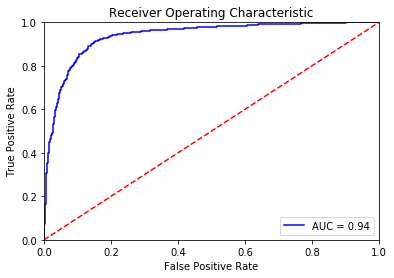

In [18]:
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

fpr, tpr, threshold = metrics.roc_curve(trues, preds)
roc_auc = metrics.auc(fpr, tpr)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [19]:
y_pred=np.array(preds)>0.5
accuracy=np.mean(y_pred==np.array(trues))
print("Accuracy is:", accuracy)

Accuracy is: 0.8879514895860796


In [20]:
dict1 = {'Pred_4NN': preds, 'Real_4NN': trues}  
df=pd.DataFrame(dict1)
df.to_csv("4LayerNNData.csv", index=False)

In [21]:
model.save("4LayerNN.h5") #save model